### Data Preperation

In [44]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from shape_synthesis.datasets.transforms import get_transform 
from shape_synthesis.datasets.qm9 import DataConfig, create_dataset, get_dataloaders


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# When turning dev=True, the dataset will be created with a smaller number of points for faster testing
dev = False

res = 32
num_dir = 16
x_dim  = res * num_dir 

num_examples = -1

# VAE settings
hidden_dim = 400
latent_dim = 100
lr_vae = 1e-3
epochs_vae = 150

# MLP settings
hidden_dims_mlp = [64, 128, 256]
lr_mlp = 1e-3
epochs_mlp = 100


batch_size = 64

config = DataConfig(
        root="./data",
        raw="./data/raw",
        batch_size=batch_size,
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'get_dataloaders' from 'shape_synthesis.datasets.qm9' (/Users/jschmidt/Dev/shape-synthesis-v2/shape_synthesis/datasets/qm9.py)

In [43]:
dataset_type = "dev" if dev else "prod"
path = f"{config.root}/qm9/{dataset_type}"

create_dataset(config, dev=dev)

train_data = torch.load(f"{path}/train.pt")

x = train_data

print(72 * "=")
print("Info")
print("Min", x.min(dim=0)[0])
print("Max", x.max(dim=0)[0])
print("Norm", torch.norm(x, dim=1).max())
print(72 * "=")

prod
Creating: ./data/qm9
Creating: ./data/raw
Saving config to ./data/qm9/prod/config.yaml
Info


AttributeError: 'QM9' object has no attribute 'min'

torch.Size([10, 3]) torch.Size([7, 3]) torch.Size([2, 3]) torch.Size([0, 3]) torch.Size([0, 3])


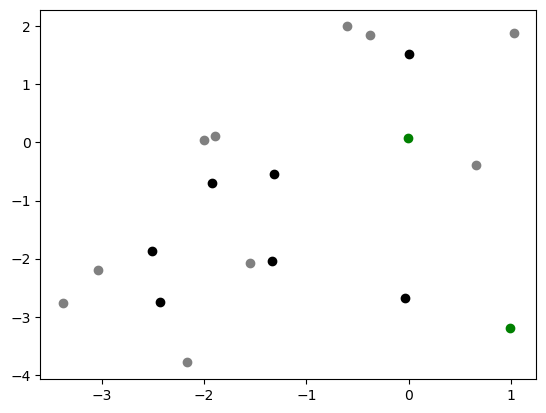

In [42]:
colors = { 1:'red', 6: 'blue', 7: 'black', 8: 'green'}
atom_types = {1: 'H', 6: 'C', 7: 'N', 8: 'O'}

pos = train_data[0].pos
z = train_data[0].z

mask_h = z == 1
mask_c = z == 6
mask_n = z == 7
mask_o = z == 8
mask_f = z == 9

plt.scatter(pos[mask_c][:, 0], pos[mask_c][:, 1], color='black', label='C')
plt.scatter(pos[mask_n][:, 0], pos[mask_n][:, 1], color='green', label='N')
plt.scatter(pos[mask_o][:, 0], pos[mask_o][:, 1], color='red', label='O')
plt.scatter(pos[mask_h][:, 0], pos[mask_h][:, 1], color='grey', label='H')
plt.scatter(pos[mask_f][:, 0], pos[mask_f][:, 1], color='blue', label='F')


In [48]:
# Preparing the channeled ECT out of the QM9 dataset

transform = get_transform(device=DEVICE, resolution=res, num_thetas=num_dir, ambient_dimension=3)

train_ects = []
train_number_atoms = []

for i in range(len(train_data)):
    pos = train_data[i].pos
    z = train_data[i].z
    
    # define filtration via atom type and channel
    mask_c = z == 6
    mask_n = z == 7 + mask_c
    mask_o = z == 8 + mask_n
    mask_f = z == 9 + mask_o
    mask_h = z == 1 + mask_f
    
    
    ect_c = torch.flatten(transform(pos[mask_c]).movedim(-1,-1), start_dim=1)
    ect_n = torch.flatten(transform(pos[mask_n]).movedim(-1,-1), start_dim=1)
    ect_o = torch.flatten(transform(pos[mask_o]).movedim(-1,-1), start_dim=1)
    ect_f = torch.flatten(transform(pos[mask_f]).movedim(-1,-1), start_dim=1)
    ect_h = torch.flatten(transform(pos[mask_h]).movedim(-1,-1), start_dim=1)
    
    ect = torch.stack([ect_c, ect_n, ect_o, ect_f, ect_h], dim=0)
    train_ects.append(ect)
    train_number_atoms.append(len(pos))
    

torch_train_ects = torch.cat(train_ects, dim=0)
torch_train_number_atoms = torch.cat(train_number_atoms, dim=0)
train_dataset = TensorDataset(torch_train_ects, torch_train_number_atoms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

RuntimeError: The size of tensor a (32) must match the size of tensor b (7) at non-singleton dimension 0

### Decoder MLP

In [ ]:
class PointCloudMLP(nn.Module):
    def __init__(self, x_input: int, hidden_dims: list, max_no_points: int):
        """
        Args:
            x_input (int): Dimension of input vector.
            hidden_dims (list): List of hidden layer sizes, e.g. [128, 256].
            no_points (int): Number of output points (point cloud size).
        """
        super(PointCloudMLP, self).__init__()
        
        # Build fully connected layers
        layers = []
        input_dim = x_input
        
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h

        # Final layer: outputting (no_points * 2) values
        layers.append(nn.Linear(input_dim, max_no_points * 3))
        
        self.network = nn.Sequential(*layers)
        self.no_points = max_no_points

    def forward(self, x, no_atoms: int):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, x_input).
            no_atoms (int): Number of atoms in molecule.
        Returns:
            torch.Tensor: Output point cloud of shape (batch_size, no_points, 2).
        """
        out = self.network(x)  # (batch_size, no_points * 2)
        out = out.view(-1, self.no_points, 3)[:, no_atoms]  # Reshape to (batch_size, no_points, 2)
        return out

In [ ]:
# Add a loss function to allow permutation invariance

def chamfer_distance(p1, p2):
    """
    p1, p2: (batch, n, 2)
    """
    diff_1 = torch.cdist(p1, p2)  # (batch, n, n)
    min_dist_1 = diff_1.min(dim=2)[0]  # (batch, n)
    min_dist_2 = diff_1.min(dim=1)[0]  # (batch, n)
    return (min_dist_1.mean() + min_dist_2.mean())

In [ ]:
x_input = res*num_dir
model2 = PointCloudMLP(x_input, hidden_dims_mlp, num_pts)

optimizer = Adam(model2.parameters(), lr=lr_mlp)
loss_fn = chamfer_distance

for epoch in range(epochs_mlp):
    overall_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.view(batch_size, x_input)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        y_hat = model2(x)
        loss = loss_fn(y, y_hat)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / ((batch_idx+1)*batch_size))